## About the Dataset

This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.

## Source of Simulation

This was generated using Sparkov Data Generation | Github tool created by Brandon Harris. This simulation was run for the duration - 1 Jan 2019 to 31 Dec 2020. The files were combined and converted into a standard format.

The simulator has certain pre-defined list of merchants, customers and transaction categories. And then using a python library called "faker", and with the number of customers, merchants that you mention during simulation, an intermediate list is created.

After this, depending on the profile you choose for e.g. "adults 2550 female rural.json" (which means simulation properties of adult females in the age range of 25-50 who are from rural areas), the transactions are created. Say, for this profile, you could check "Sparkov | Github | adults_2550_female_rural.json", there are parameter value ranges defined in terms of min, max transactions per day, distribution of transactions across days of the week and normal distribution properties (mean, standard deviation) for amounts in various categories. Using these measures of distributions, the transactions are generated using faker.

What I did was generate transactions across all profiles and then merged them together to create a more realistic representation of simulated transactions.

## Acknowledgements

Brandon Harris for his amazing work in creating this easy-to-use simulation tool for creating fraud transaction datasets.

### Import the necessary libraries

In [1]:
# Path to user functions
import sys
sys.path.append("../Src/")
# display Python Version
from platform import python_version
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# user functions
import utilities as u

# Initialize variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

Numpy Version: 2.3.1
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.10.0
Python Version: 3.13.5


### Load the dataset & Combine the train and test datasets

In [2]:
# Load the CSV files
print("Loading fraudTrain.csv...")
fraud_train = pd.read_csv("../Data/fraudTrain.csv")
print(f"Training data shape: {fraud_train.shape}")

print("\nLoading fraudTest.csv...")
fraud_test = pd.read_csv("../Data/fraudTest.csv")
print(f"Test data shape: {fraud_test.shape}")

# Combine the datasets
print("\nCombining datasets...")
df = pd.concat([fraud_train, fraud_test], ignore_index=True)
print(f"Combined data shape: {df.shape}")

# reset index after concatenation
df.reset_index(drop=True, inplace=True)

# # Display basic information about the combined dataset
# print("\nDataset Info:")
# print(df.info())

# print("\nFirst few rows:")
# print(df.head())

# print("\nDataset columns:")
# print(df.columns.tolist())

Loading fraudTrain.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Test data shape: (555719, 23)

Combining datasets...
Combined data shape: (1852394, 23)
Test data shape: (555719, 23)

Combining datasets...
Combined data shape: (1852394, 23)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [4]:
# Checking for nulls
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [5]:
df.is_fraud.value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [6]:
df.is_fraud.value_counts(normalize=True)

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64

### Observations :
- From above we can observe that there is 23 features and 1,852,394 rows
- This is highly imbalanced class data
    - We can try with the imbalabnce but we need to balance the dependent variable

In [7]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Data Wrangling

In [8]:
# # remove columns
# remove_cols = ['Unnamed: 0', 'street', 'trans_num', 'unix_time', ]
# # drop columns
# df.drop(columns=remove_cols, inplace=True, errors='ignore')

# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
# Convert dob to datetime
df['dob'] = pd.to_datetime(df['dob'])

# display
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [9]:
# remove 'fraud_' prefix from the 'merchant' column
df['merchant'] = df['merchant'].str.replace('^fraud_', '', regex=True)
# determine month, day of the week
df['trans_month'] = df.trans_date_trans_time.dt.month_name()
df['trans_day_of_week'] = df.trans_date_trans_time.dt.day_name()
df['trans_hour'] = df.trans_date_trans_time.dt.hour



df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_month,trans_day_of_week,trans_hour
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,January,Tuesday,0
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,January,Tuesday,0
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,January,Tuesday,0
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,January,Tuesday,0
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,January,Tuesday,0


In [10]:
# Create a mapping for industry identifier
mii_to_industry = {
    '1': 'Airlines',
    '2': 'Airlines & Financial',
    '3': 'Travel & Entertainment (e.g., American Express, Diners Club)',
    '4': 'Banking & Financial (e.g., Visa)',
    '5': 'Banking & Financial (e.g., Mastercard)',
    '6': 'Merchandising & Banking (e.g., Discover)',
    '7': 'Petroleum',
    '8': 'Healthcare & Telecommunications',
    '9': 'National Assignment / Other'
}

# apply lamda function to map first digit of cc_num to industry
df['industry'] = df['cc_num'].apply(lambda x: u.map_first_digit_to_value(x, mapping_dict=mii_to_industry))

# determe credit card network
df['cc_network'] = df['cc_num'].apply(lambda x: u.get_credit_card_network(str(x)))

# determine store distance
df['store_distance'] = df.apply(
    lambda x: u.haversine_distance_calc(x['lat'], x['long'], x['merch_lat'], x['merch_long']),
    axis=1
)

# Display the first few rows of the updated DataFrame
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_time,merch_lat,merch_long,is_fraud,trans_month,trans_day_of_week,trans_hour,industry,cc_network,store_distance
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1325376018,36.011293,-82.048315,0,January,Tuesday,0,Airlines & Financial,Mastercard,48.838332
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1325376044,49.159047,-118.186462,0,January,Tuesday,0,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,1325376051,43.150704,-112.154481,0,January,Tuesday,0,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1325376076,47.034331,-112.561071,0,January,Tuesday,0,"Travel & Entertainment (e.g., American Express...",JCB,59.448671
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,1325376186,38.674999,-78.632459,0,January,Tuesday,0,"Travel & Entertainment (e.g., American Express...",American Express,48.191592


In [13]:
# Define Non-ordered categorical columns
cat_cols = ['merchant', 'category', 'gender', 'city','state', 'zip','job','is_fraud', 'industry', 'cc_network']
df[cat_cols] = df[cat_cols].astype('category')
# ordered categorical columns
ord_cols = ['trans_month', 'trans_day_of_week']

# Define the order of months and days of the week for plotting
month_order = ["January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"]
df['trans_month'] = pd.Categorical(df['trans_month'], categories=month_order, ordered=True)
#
day_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['trans_day_of_week'] = pd.Categorical(df['trans_day_of_week'], categories=day_of_week_order, ordered=True)

# Convert 'is_fraud' to a numeric type (int or float)
df['is_fraud'] = df['is_fraud'].astype(int)  # or float, depending on your data



## Visualization

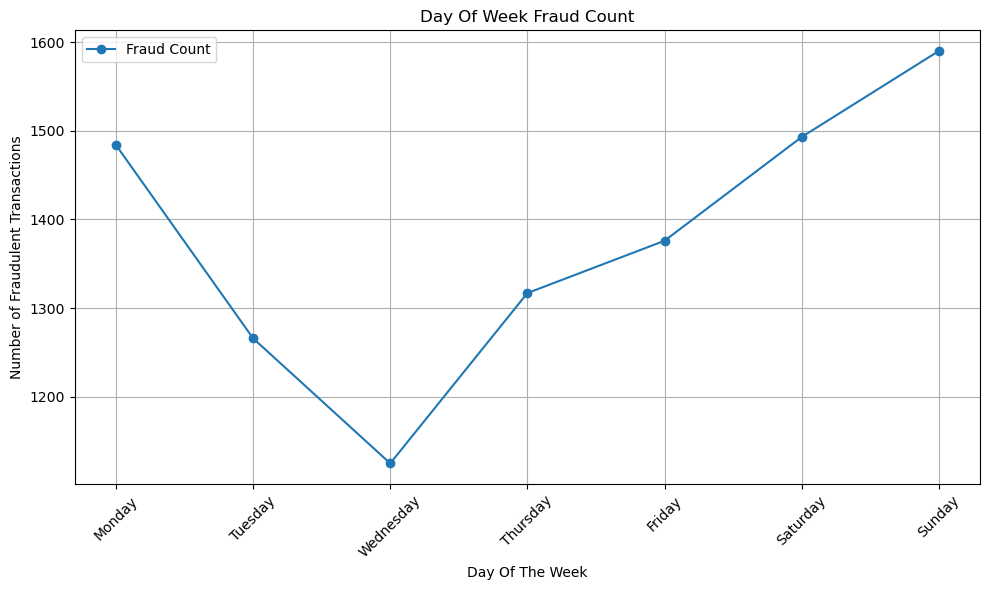

In [14]:
# monthly summary
df_day_of_week = (
    df.groupby('trans_day_of_week', observed=True)
      .agg(
          total_transactions=('is_fraud', 'count'),
          total_fraud=('is_fraud', 'sum')
      )
      .sort_values(by='trans_day_of_week')
      .reset_index()
)

# plotting the monthly fraud count
plt.figure(figsize=(10, 6))
plt.plot(df_day_of_week['trans_day_of_week'], df_day_of_week['total_fraud'], marker='o', label='Fraud Count')
plt.title('Day Of Week Fraud Count')
plt.xlabel('Day Of The Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

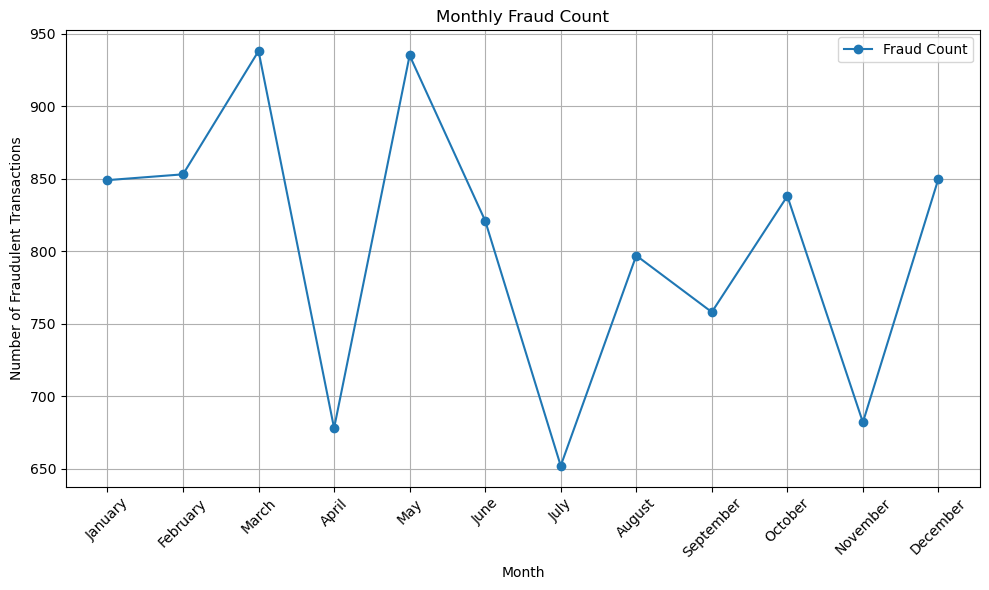

In [15]:
# monthly summary
df_monthly = (
    df.groupby('trans_month', observed=True)
      .agg(
          total_transactions=('is_fraud', 'count'),
          total_fraud=('is_fraud', 'sum')
      )
      .sort_values(by='trans_month')
      .reset_index()
)

# plotting the monthly fraud count
plt.figure(figsize=(10, 6))
plt.plot(df_monthly['trans_month'], df_monthly['total_fraud'], marker='o', label='Fraud Count')
plt.title('Monthly Fraud Count')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
